# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures_batches", data_format='batches')

In [5]:
# batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
#                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30   # количество тем
subjective_topics=["sbj"+str(i) for i in range(T-1)]
common_topic=["bcg"]
topic_names=subjective_topics+common_topic
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, seed=1, cache_theta=True, class_ids={"text":1,"author":1})

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [7]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model_artm.initialize("dictionary")

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
model_artm.scores.add(artm.TopTokensScore(name="text_top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="authors_top_words", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=1e5, dictionary=dictionary, class_ids="text", topic_names="bcg"))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', tau=-1e5, dictionary=dictionary, class_ids="text", topic_names=subjective_topics))

Выполните еще 15 проходов по коллекции.

In [12]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [13]:
def show_tops(model, score_tracker):
    for topic_name in model.topic_names:
        print topic_name + ': ',
        tokens = model.score_tracker[score_tracker].last_tokens
        for word in tokens[topic_name]:
            print word,
        print

In [14]:
# Ваш код authors_top_words
show_tops(model_artm, "authors_top_words")

sbj0:  Дмитрий_Казаков Михаил_Данилов Сергей_Майоров Виктор_Брагута Павел_Пахлов Лев_Дудко Сергей_Троицкий Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Игорь_Волобуев Валерий_Рубаков Дэвид_Гросс Жан-Арыс_Джилкибаев Аркадий_Цейтлин
sbj1:  Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Иван_Сорокин Евгений_Гудилин Дмитрий_Гольберг Валентин_Крапошин Алексей_Хохлов Дмитрий_Клинов Сергей_Морозов Вадим_Бражкин Владимир_Комлев Пётр_Образцов
sbj2:  Александр_Марей Кирилл_Мартынов Алексей_Юдин Михаил_Бойцов Александр_Павлов Фёдор_Успенский Иван_Ладынин Дина_Гусейнова Рафаэль_Арутюнян Ольга_Тогоева Александр_Воеводский Юрий_Рогулёв Владимир_Малахов Владимир_Петрухин Руслан_Хестанов
sbj3:  Виктор_Вахштайн Андрей_Лукашов Максим_Демин Татьяна_Клячко Борис_Миркин Алексей_Котов Дмитрий_Балалыкин Сергей_Зенкин Татьяна_Котова Максим_Кронгауз Владимир_Миронов Ян_Левченко Алексей_Рубцов Александр_Филиппов Михаил_Маяцкий
sbj4:  Филипп_Хайтович Владимир_Спиридонов Надежда_Он

In [15]:
# Ваш код text_top_words
show_tops(model_artm, "text_top_words")

sbj0:  частица энергия взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя заряд протон масса бозон ускоритель
sbj1:  материал температура структура химический вещество соединение поверхность свойство химия молекула давление углерод сверхпроводимость металл полимер
sbj2:  политический государство власть царь партия церковь народ правитель император средневековый враг сага шмитт государь папа
sbj3:  знание социология социологический познание школа предмет социолог факультет виктор аргумент концепт кафедра логика высказывание прикладной
sbj4:  мозг нейрон мышление предложение категория чтение взрослый синтаксический синтаксис лицо обезьяна детство шимпанзе библиотека игрушка
sbj5:  бог миф греческий герой мифология религия душа ритуал грек море мифологический гусейнов божество культ шумерский
sbj6:  русский слово текст словарь перевод корпус гласный согласный говор немецкий древнерусский академия цитата произносить издание
sbj7:  раса трудность африка праздник

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите его в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [16]:
sbj_topic_labels = [u"Релятивистская физика", u"Химия", u"История", u"Социология", u"Нейронные сети",
                    u"Древние цивилизации", u"Русский язык", u"География", u"Юриспруденция", u"Медицина",
                    u"Биология", u"Психология", u"Зарождение Руси", u"Общенаучная", u"Астрономия",
                    u"Экономика", u"Семья", u"Машинное обучение", u"История Китая", u"Генетика",
                    u"Квантовая физика", u"Философия", u"История революций", u"СССР", u"Лингвистика",
                    u"Математика", u"Театр", u"Астрономия", u"Кинематограф"]   # запишите названия тем в список
topic_labels = sbj_topic_labels + [u"Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [17]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=["author"])
print "Theta shape: ", theta.shape
print "Phi shape: ", phi_a.shape

Theta shape:  (30, 1728)
Phi shape:  (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

C:\Program Files\Anaconda2\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


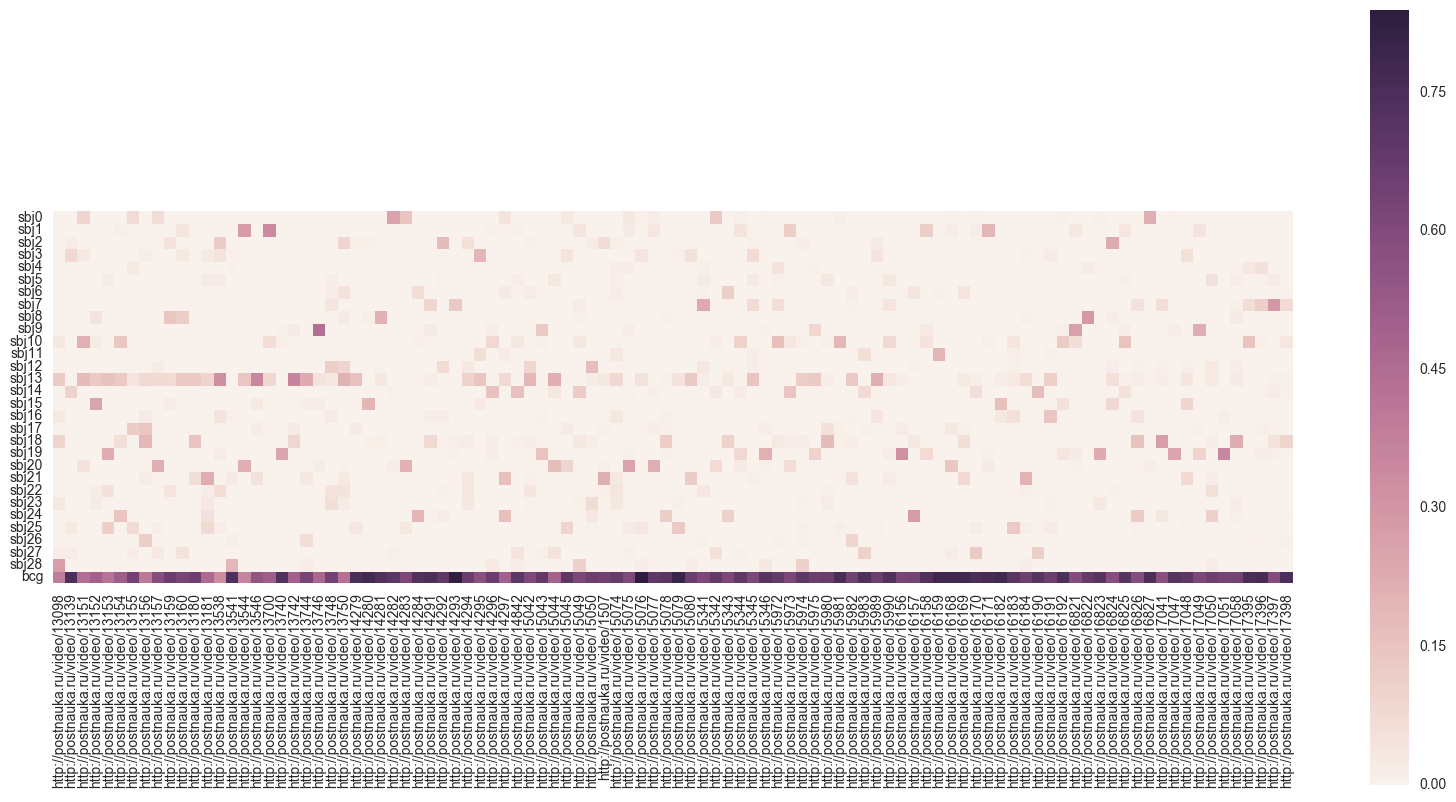

In [18]:
theta_frame = theta[theta.columns[:100]]
plt.figure(figsize=(20,10))
seaborn.heatmap(theta_frame, square=True)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [32]:
# Ваш код
probabilities_row_sum = (theta.sum(axis=1)).to_frame()
probabilities_sum = probabilities_row_sum.sum()
probabilities_frame = probabilities_row_sum/probabilities_sum
probabilities_frame = probabilities_frame.rename(index=str, columns={0:"p(t)"})
sorted_probabilities = probabilities_frame.sort_values(by=["p(t)"], ascending=False)
probabilities_frame.sum()

p(t)    1.0
dtype: float32

In [33]:
sorted_probabilities.head(7)

,p(t)
bcg,0.678245
sbj13,0.041830
sbj19,0.021660
sbj20,0.015672
sbj21,0.014536
sbj10,0.014475
sbj1,0.013316


In [34]:
sorted_probabilities.tail(3)

,p(t)
sbj28,0.005720
sbj7,0.004784
sbj26,0.002961


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

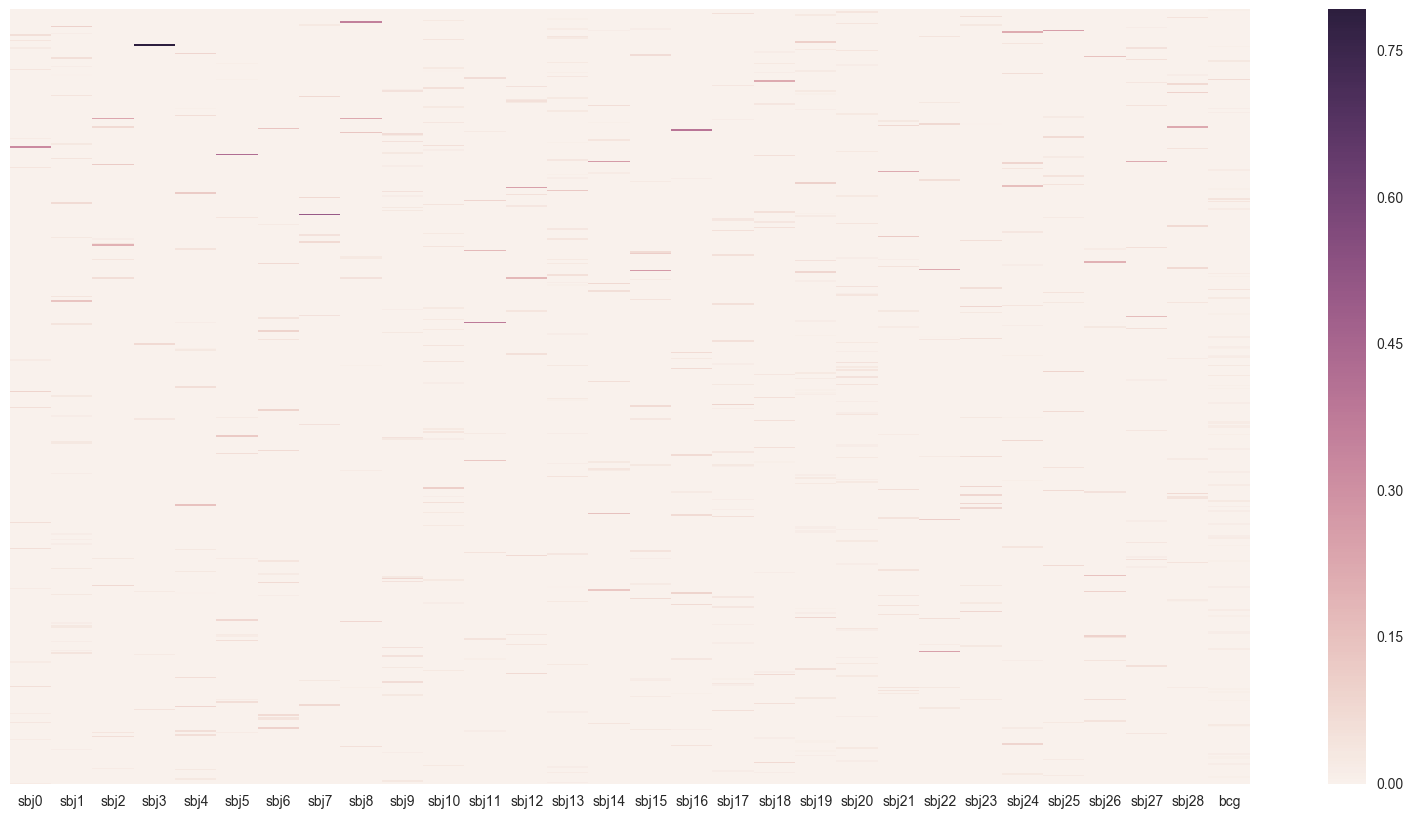

In [35]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [36]:
author_themes = pd.DataFrame(columns=["Count"])
for index, row in phi_a.iterrows():
    count = 0
    for col_index, item in row.iteritems():
        if(item > 0.01):
            count = count + 1
    author_themes.loc[index] = count

In [37]:
author_themes.sort_values(by=["Count"], ascending=False).head(7)

,Count
Ольга_Вайнштейн,4.0
Фёдор_Успенский,3.0
Андрей_Журавлев,3.0
Дина_Гусейнова,3.0
Александр_Воеводский,3.0
Екатерина_Щербакова,2.0
Андрей_Глазовский,2.0


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [38]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [39]:
# Ваш код
pts = probabilities_frame.as_matrix()
pats = phi_a.as_matrix()

In [40]:
print pats.shape
print pts.shape

(539L, 30L)
(30L, 1L)


In [41]:
ptas = np.zeros(pats.shape, dtype='float')

In [42]:
for author_index in range(0, len(ptas)):
    apats = pats[author_index]
    themes_count = len(apats)
    pa = 0
    for theme_index in range(0, themes_count):
        pa = pa + apats[theme_index]*pts[theme_index]
    for theme_index in range(0, themes_count):
        pat = apats[theme_index]
        pt = pts[theme_index]
        ptas[author_index][theme_index] = pat*pt/pa
authors_profiles = pd.DataFrame(ptas, index=phi_a.index.values, columns=phi_a.columns)
authors_profiles.shape

(539, 30)

In [43]:
reduce_model = MDS(2).fit_transform(ptas)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

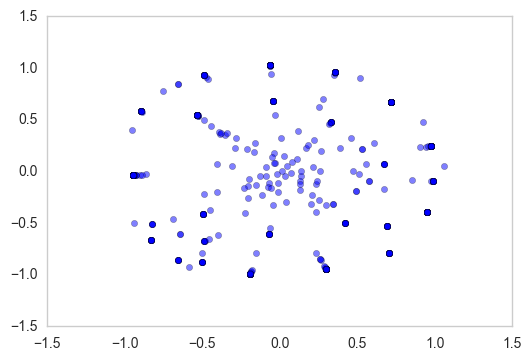

In [44]:
map_x,map_y = zip(*reduce_model)
plt.scatter(map_x, map_y, alpha=0.5)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [45]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
t_colors = zip(probabilities_frame.index, colors, pts)

max_ptas = []
for author_index in range(0,len(ptas)):
    aptas = ptas[author_index]
    max_theme_p = 0
    max_theme_index = 0
    for theme_index in range(0, len(aptas)):
        theme_probability = aptas[theme_index]
        if(theme_probability > max_theme_p):
            max_theme_p = theme_probability
            max_theme_index = theme_index
    max_ptas.append((max_theme_index, max_theme_p))

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


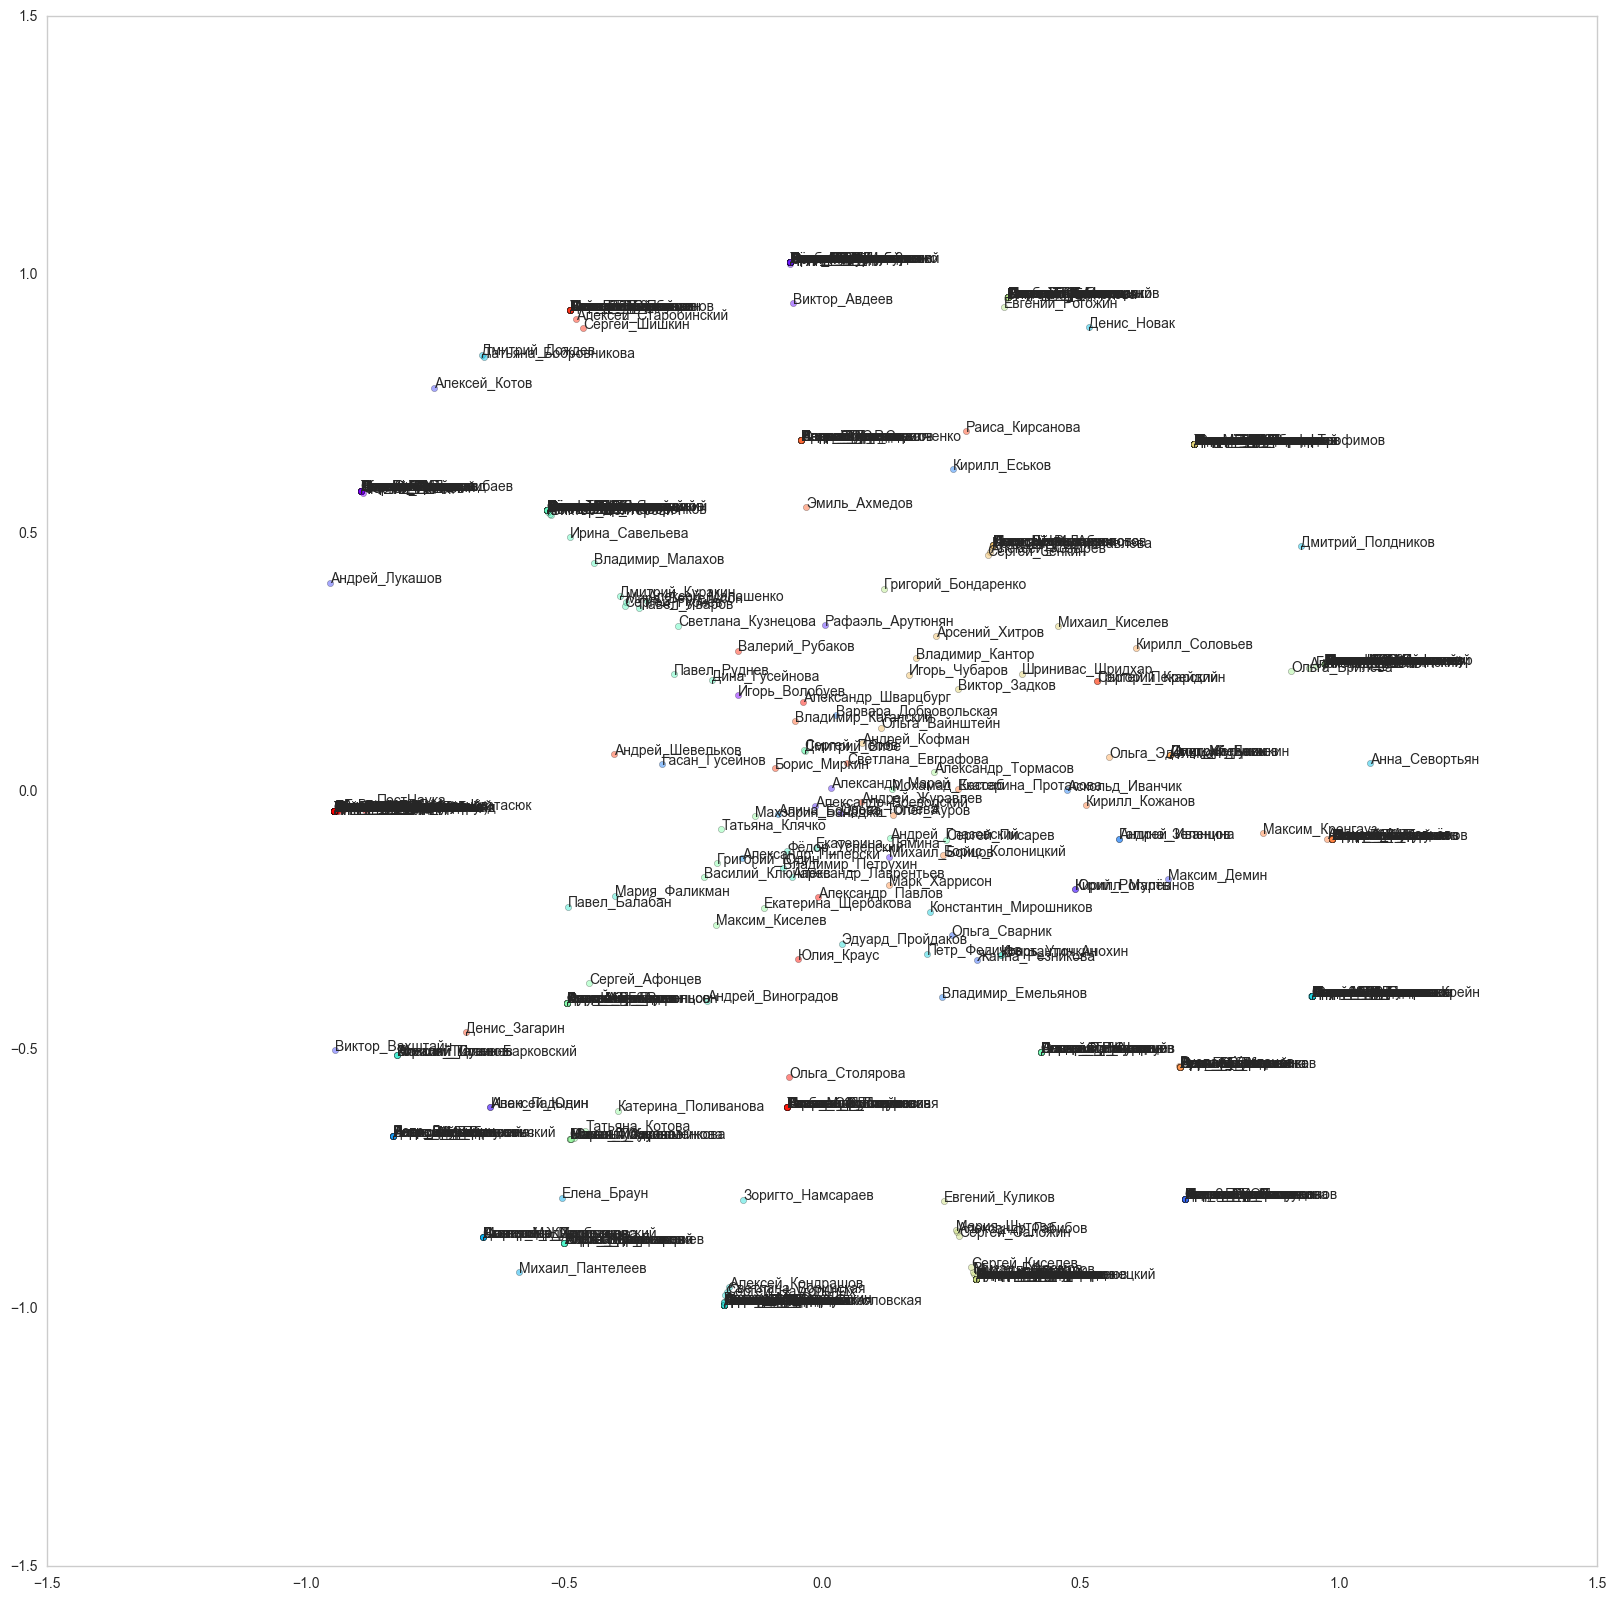

In [46]:
plt.figure(figsize=(20,20))
for author_index in range(0, len(ptas)):
    aptas = ptas[author_index]
    max_theme_index,max_theme_p = max_ptas[author_index]
    point_x = map_x[author_index]
    point_y = map_y[author_index]
    plt.scatter(point_x, 
                point_y, c=t_colors[max_theme_index][1], alpha=0.5)
    plt.annotate(author_themes.index[author_index], (point_x,point_y))
plt.legend()
plt.savefig("authors_map.pdf", format="pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [47]:
# Ваш код
theta_matrix = theta.as_matrix()
pdts = np.zeros(theta_matrix.shape, dtype='float')
for row_index in range(0, len(theta_matrix)):
    theta_row = theta_matrix[row_index]
    row_sum = sum(theta_row)
    for col_index in range(0, len(theta_row)):
        ptd = theta_row[col_index]
        pdts[row_index][col_index] = ptd/row_sum

In [48]:
max_doc_indices = np.argmax(pdts, axis=1)
pdts.shape

(30L, 1728L)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [49]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [50]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [51]:
# Ваш код
for theme_index in range(0, len(sbj_topic_labels)):
    display(HTML(u"<h1>" + sbj_topic_labels[theme_index] + u"</h1>"))
    display(HTML(u"<ul>"))
    labeled_docs = sorted(zip(theta.columns,pdts[theme_index]), key=lambda doc: doc[1])[:10]
    for name,pdt in labeled_docs:
        display(HTML(u"<li><a href='" + name + "'>" + name + u"</a></li>"))
    display(HTML(u"</ul>"))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 